<a href="https://colab.research.google.com/github/teoalcdor/tfg_teoalcdor/blob/main/segmentation_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Limpieza del Conjunto de Datos Segmentación

Vamos a preparar el dataset de segmentación para entrenar nuestros modelos. En este notebook nos vamos a asegurar de que a cada máscara le corresponda una única imagen y a cada imagen una única máscara, cada máscara esté en formato PNG y cada imagen en formate JPG, no haya imagenes comunes entre los subconjuntos de entrenamiento, validación y test, las máscaras tengan la misma forma que las imágenes a las que están asociadas. Los tres canales de cada máscara sean iguales y las etiquetas de cada píxel de las máscaras esté dentro del conjunto de etiquetas válido. También vamos a ver qué proporción de píxeles de cada clase hay en cada uno de los tres subconjuntos.

Comenzamos importando las librerías que vamos a usar:

## Librerías

In [ ]:
from collections import Counter
import cv2
import glob
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import shutil
import time
import tqdm

## Funciones Auxiliares

Definimos las funciones que vamos a utilizar para limpiar el dataset:

In [ ]:
POSSIBLE_ERRORS = ["Shapes don't match", "Mask channels don't match", "Incorrect mask labels"]

In [ ]:
def is_valid(image, mask):
    """
    Devuelve una lista con las razones por la cual un par imagen-mascara no es
    válido si las hubiera.
    """
    messages = []

    # Casan las formas?
    if image.shape != mask.shape or \
       image.shape[0] != 640 or image.shape[1] != 640 or \
       mask.shape[0] != 640 or mask.shape[1] != 640:

        messages.append(POSSIBLE_ERRORS[0])

    # Son iguales todos los canales de la mascara?
    if  np.all(mask[:, :, 0] != mask[:, :, 1]) or np.all(mask[:, :, 1] != mask[:, :, 2]):
        messages.append(POSSIBLE_ERRORS[1])

    # Son validas todas las etiquetas de la mascara?
    # (Se toma solo el primer canal, si no fueran iguales todos los canales,
    # el par ya seria invalido por el anterior punto)
    if not set(np.unique(mask[:, :, 0])).issubset(POSSIBLE_LABELS):
        messages.append(POSSIBLE_ERRORS[2])

    return messages


def check_data(path, images):
    """
    Verifica que los pares imagen-mascara de una ruta sean válidos y devuelve
    un diccionario con los pares no válidos y sus problemas. Este diccionario
    se puede convertir fácilmente en un DataFrame de pandas.
    """

    # Imprimimos de que directorio sacamos los pares
    print(f"Folder: {path}")

    # Inicializamos el diccionario con los errores
    corrupt_data = {
            "filename": [],
            POSSIBLE_ERRORS[0]: [],
            POSSIBLE_ERRORS[1]: [],
            POSSIBLE_ERRORS[2]: [],
        }

    # Verificamos la integridad de cada par mascara-imagen
    n_images = len(images)

    for image in tqdm.tqdm(images, total=n_images, desc="Validating pairs"):

        # Leemos la imagen y su mascara
        image_path = path + image + ".jpg"
        mask_path = path + image + "_mask.png"

        img = cv2.imread(image_path)
        mask = cv2.imread(mask_path)

        # Comprobamos si el par es valido
        messages = is_valid(img, mask)

        # Si hay algun mensaje de error, el par es corrupto y lo registramos
        if messages:
            corrupt_data["filename"].append(image)
            for error in POSSIBLE_ERRORS:
                if error in messages:
                    corrupt_data[error].append(1)
                else:
                    corrupt_data[error].append(0)

    # Imprimimos algunas estadisticas
    print()
    print(f" - Number of corrupt pairs: {len(corrupt_data['filename'])} of {n_images}")
    print(f" - {POSSIBLE_ERRORS[0]}: {sum(corrupt_data[POSSIBLE_ERRORS[0]])}")
    print(f" - {POSSIBLE_ERRORS[1]}: {sum(corrupt_data[POSSIBLE_ERRORS[1]])}")
    print(f" - {POSSIBLE_ERRORS[2]}: {sum(corrupt_data[POSSIBLE_ERRORS[2]])}")
    print()

    return corrupt_data


def count_pixels(folder_path):
    """
    Cuenta los píxeles de cada clase en una carpeta de imágenes.
    """
    # Selecciona todas las mascaras (que han de estar en PNG) de la carpeta
    images = glob.glob(f"{folder_path}/*.png")
    n_images = len(images)

    # Para cada imagen, cuenta sus pixeles
    counter = Counter()
    for image_path in tqdm.tqdm(images, total=n_images, desc="Processing images"):
        image = cv2.imread(image_path)
        counter.update(image[:, :, 0].flatten()) # Solo contamos un canal, los
                                                 # tres canales son iguales
    return counter


def get_distribution_of_pixels(folder_path):
    """
    Obtiene la distribución de píxeles de cada clase en una carpeta de imágenes.
    """

    # Contamos los pixeles
    pixels = count_pixels(folder_path)

    # Calculamos el total de pixeles
    total_pixels = sum(pixels.values())

    # Calculamos el porcentaje de pixeles de fondo y de objetos
    bg_pixels = (pixels[0] / total_pixels) * 100
    object_pixels = 100 - bg_pixels

    # Quitamos el fondo para la grafica de barras de los objetos
    pixels.pop(0)

    # Grafica de barras de los objetos
    fig, axs = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 3]))
    sns.barplot(
        x=x_pixel_values, y=y_pixel_values, hue=[str(key) for key in pixels.keys()], legend=False,
        ax=axs[0]
    ).set(title="Pixels per Object Class", xlabel="Class", ylabel="Number of Pixels")

    # Grafica de barras fondo vs objetos
    x_percentage_values = ["Background", "Objects"]
    y_percentage_values = [bg_pixels, object_pixels]
    x_pixel_values = list(pixels.keys())
    y_pixel_values = np.array(list(pixels.values()))

    sns.barplot(
        x=x_percentage_values, y=y_percentage_values, hue=x_percentage_values,
        legend=False, ax=axs[1]
    ).set(title="Distribution of Pixels", xlabel="Type", ylabel="Percentage of Pixels")

    fig.tight_layout()

    plt.show()

    return pixels

In [ ]:
%matplotlib inline

## Carga de los Datos

Montamos nuestra cuenta de Google Drive:

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


Descomprimimos el archivo:

In [ ]:
zip_path = "/content/drive/MyDrive/tfg/datasets/semantic_segmentation_dataset.zip"
extract_path = "/content/"
!unzip -q "$zip_path" -d "$extract_path"

Cargamos las etiquetas:

In [ ]:
labels = pd.read_csv("/content/semantic_segmentation_dataset/train/_classes.csv")
labels

,Pixel Value,Class
0,0,background
1,1,RU_airforce
2,2,RU_army
3,3,RU_marines
4,4,RU_navy
5,5,US_airforce
6,6,US_army
7,7,US_marines
8,8,US_navy


Extraemos las etiquetas posibles:

In [ ]:
POSSIBLE_LABELS = set(labels["Pixel Value"].values)

## Correspondencia entre Imágenes y Máscaras y Formato

In [ ]:
# Conjunto de entrenamiento
train_images = set()
masks = set()
extensions = set()

for filename in os.listdir("semantic_segmentation_dataset/train/"):
    name = filename[:-4]
    extension = filename[-3:]
    extensions.add(extension)
    if extension == "jpg":
        train_images.add(name)
    elif extension == "png": # Si la extension es png debe ser una mascara
        if name[-5:] == "_mask":
            masks.add(name[:-5])

# Todos los archivos estan en jpg, png o csv y hay tantas imagnes como mascaras?
(extensions == {"jpg", "png", "csv"}) and (train_images == masks)

True

In [ ]:
# Conjunto de validacion
val_images = set()
masks = set()
extensions = set()

for filename in os.listdir("semantic_segmentation_dataset/valid/"):
    name = filename[:-4]
    extension = filename[-3:]
    extensions.add(extension)
    if extension == "jpg":
        val_images.add(name)
    elif extension == "png": # Si la extension es png debe ser una mascara
        if name[-5:] == "_mask":
            masks.add(name[:-5])

# Todos los archivos estan en jpg, png o csv y hay tantas imagnes como mascaras?
(extensions == {"jpg", "png", "csv"}) and (val_images == masks)

True

In [ ]:
# Conjunto test
test_images = set()
masks = set()
extensions = set()

for filename in os.listdir("semantic_segmentation_dataset/test/"):
    name = filename[:-4]
    extension = filename[-3:]
    extensions.add(extension)
    if extension == "jpg":
        test_images.add(name)
    elif extension == "png":
        if name[-5:] == "_mask": # Si la extension es png debe ser una mascara
            masks.add(name[:-5])

# Todos los archivos estan en jpg, png o csv y hay tantas imagnes como mascaras?
(extensions == {"jpg", "png", "csv"}) and (test_images == masks)

True

Existe una correspondencia biyectiva entre imagenes y máscaras. Todas las las imágenes están en JPG y todas las máscaras en PNG.

## No Intersección del los Subconjuntos

In [ ]:
print(train_images & val_images)
print(train_images & test_images)
print(val_images & test_images)

set()
set()
set()


La partición en datos de entrenamiento, validación y test es, efectivamente, una partición. Lo anterior no podría deducirse si no supiésemos que existe una correspondencia de uno a uno entre máscaras e imágenes.

## Pares Imagen-Máscara Corruptos

In [ ]:
corrupt_data_train = pd.DataFrame(check_data("semantic_segmentation_dataset/train/", train_images))
corrupt_data_val = pd.DataFrame(check_data("semantic_segmentation_dataset/valid/", val_images))
corrupt_data_test = pd.DataFrame(check_data("semantic_segmentation_dataset/test/", test_images))

Folder: semantic_segmentation_dataset/train/


Validating pairs: 100%|██████████| 2328/2328 [00:46<00:00, 49.65it/s]



 - Number of corrupt pairs: 219 of 2328
 - Shapes don't match: 219
 - Mask channels don't match: 0
 - Incorrect mask labels: 0

Folder: semantic_segmentation_dataset/valid/


Validating pairs: 100%|██████████| 220/220 [00:05<00:00, 37.85it/s]



 - Number of corrupt pairs: 20 of 220
 - Shapes don't match: 20
 - Mask channels don't match: 0
 - Incorrect mask labels: 0

Folder: semantic_segmentation_dataset/test/


Validating pairs: 100%|██████████| 104/104 [00:02<00:00, 36.05it/s]


 - Number of corrupt pairs: 8 of 104
 - Shapes don't match: 8
 - Mask channels don't match: 0
 - Incorrect mask labels: 0



## Creación de un Dataset de Imágenes con Anotaciones Corruptas


Crearemos este dataset con el objetivo de volver a etiquetar estás imágenes si fuera necesario.

Creamos la estructura de los ficheros del dataset:


In [ ]:
os.makedirs("/content/corrupt_semantic_segmentation_dataset")
os.makedirs("/content/corrupt_semantic_segmentation_dataset/train")
os.makedirs("/content/corrupt_semantic_segmentation_dataset/valid")
os.makedirs("/content/corrupt_semantic_segmentation_dataset/test")

Movemos las imágenes corruptas y sus anotaciones al dataset:

In [ ]:
# Conjunto de entrenamiento
for filename in corrupt_data_train["filename"]:
    shutil.move(
        f"semantic_segmentation_dataset/train/{filename}.jpg",
        "corrupt_semantic_segmentation_dataset/train/"
    )
    shutil.move(
        f"semantic_segmentation_dataset/train/{filename}_mask.png",
        "corrupt_semantic_segmentation_dataset/train/"
    )

# Conjunto de validacion
for filename in corrupt_data_val["filename"]:
    shutil.move(
        f"semantic_segmentation_dataset/valid/{filename}.jpg",
        "corrupt_semantic_segmentation_dataset/valid/"
    )
    shutil.move(
        f"semantic_segmentation_dataset/valid/{filename}_mask.png",
        "corrupt_semantic_segmentation_dataset/valid/"
    )

# Conjunto test
for filename in corrupt_data_test["filename"]:
    shutil.move(
        f"semantic_segmentation_dataset/test/{filename}.jpg",
        "corrupt_semantic_segmentation_dataset/test/"
    )
    shutil.move(
        f"semantic_segmentation_dataset/test/{filename}_mask.png",
        "corrupt_semantic_segmentation_dataset/test/"
    )

## Estudio Descriptivo

Veamos las distribuciones de los píxeles en de los pares no corruptos de cada subconjunto:

Processing images: 100%|██████████| 2109/2109 [07:49<00:00,  4.50it/s]


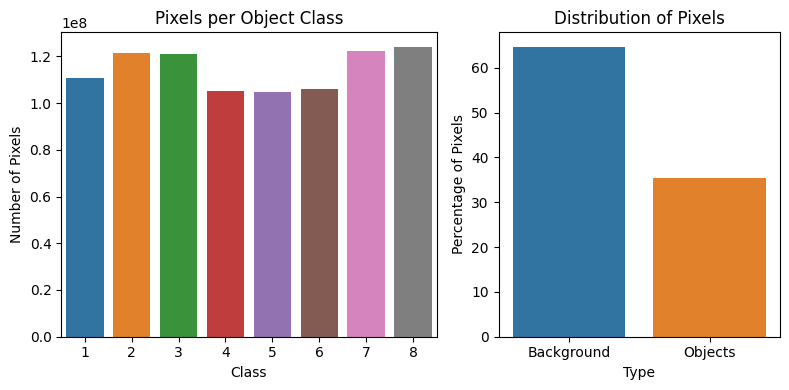

In [ ]:
# Entrenamiento
_ = get_distribution_of_pixels("semantic_segmentation_dataset/train/")

Processing images: 100%|██████████| 200/200 [00:42<00:00,  4.74it/s]


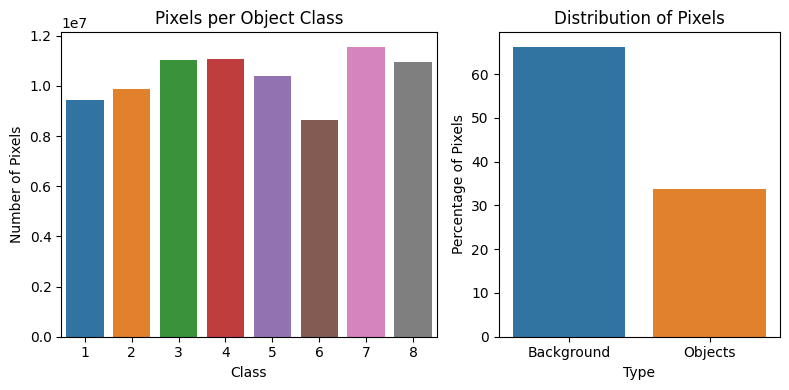

In [ ]:
# Validacion
_ = get_distribution_of_pixels("semantic_segmentation_dataset/valid/")

Processing images: 100%|██████████| 96/96 [00:21<00:00,  4.46it/s]


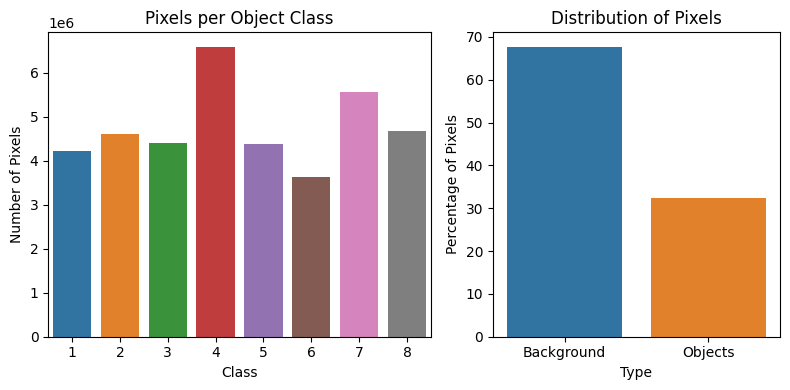

In [ ]:
# Test
_ = get_distribution_of_pixels("semantic_segmentation_dataset/test/")

Ahora hacemos lo mismo para las mascaras de los pares corruptos:

Processing images: 100%|██████████| 219/219 [04:54<00:00,  1.34s/it]


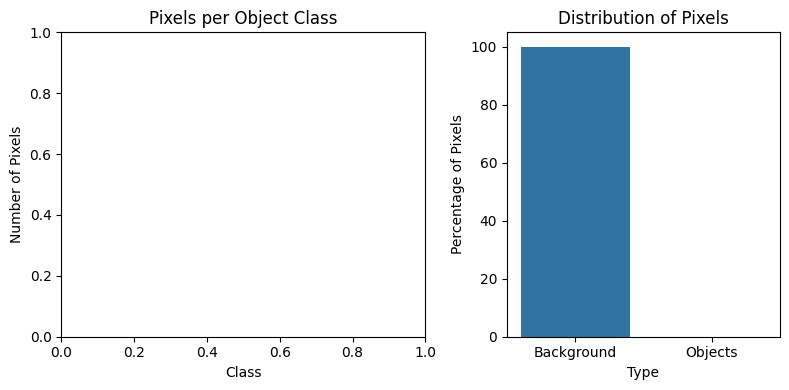

In [ ]:
# Entrenamiento
_ = get_distribution_of_pixels("corrupt_semantic_segmentation_dataset/train/")

Processing images: 100%|██████████| 20/20 [01:06<00:00,  3.33s/it]


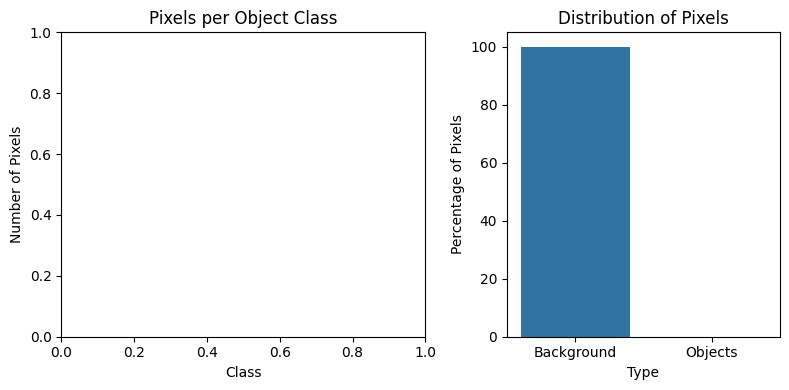

In [ ]:
# Validacion
_ = get_distribution_of_pixels("corrupt_semantic_segmentation_dataset/valid/")

Processing images: 100%|██████████| 8/8 [00:33<00:00,  4.21s/it]


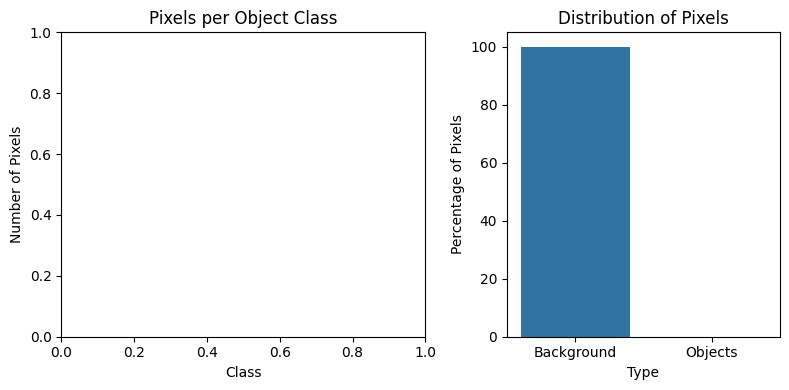

In [ ]:
# Test
_ = get_distribution_of_pixels("corrupt_semantic_segmentation_dataset/test/")

Vemos que todos los pares corruptos se corresponden con imágenes negativas (solo fondo), por lo que no hay poblemas en redimensionarlas y añadirlas otra vez al *dataset* como pares válidos:

In [ ]:
# Entrenamiento
for filename in corrupt_data_train["filename"]:
    image = cv2.imread(f"/content/corrupt_semantic_segmentation_dataset/train/{filename}.jpg")
    mask = cv2.imread(f"/content/corrupt_semantic_segmentation_dataset/train/{filename}_mask.png")

    image = cv2.resize(image, (640, 640))
    mask = cv2.resize(mask, (640, 640))

    cv2.imwrite(f"/content/semantic_segmentation_dataset/train/{filename}.jpg", image)
    cv2.imwrite(f"/content/semantic_segmentation_dataset/train/{filename}_mask.png", mask)

# Validacion
for filename in corrupt_data_val["filename"]:
    image = cv2.imread(f"/content/corrupt_semantic_segmentation_dataset/valid/{filename}.jpg")
    mask = cv2.imread(f"/content/corrupt_semantic_segmentation_dataset/valid/{filename}_mask.png")

    image = cv2.resize(image, (640, 640))
    mask = cv2.resize(mask, (640, 640))

    cv2.imwrite(f"/content/semantic_segmentation_dataset/valid/{filename}.jpg", image)
    cv2.imwrite(f"/content/semantic_segmentation_dataset/valid/{filename}_mask.png", mask)

# Test
for filename in corrupt_data_test["filename"]:
    image = cv2.imread(f"/content/corrupt_semantic_segmentation_dataset/test/{filename}.jpg")
    mask = cv2.imread(f"/content/corrupt_semantic_segmentation_dataset/test/{filename}_mask.png")

    image = cv2.resize(image, (640, 640))
    mask = cv2.resize(mask, (640, 640))

    cv2.imwrite(f"/content/semantic_segmentation_dataset/test/{filename}.jpg", image)
    cv2.imwrite(f"/content/semantic_segmentation_dataset/test/{filename}_mask.png", mask)

Vemos qué distribución de los píxeles queda con los pares corruptos arreglados:

Processing images: 100%|██████████| 2328/2328 [03:03<00:00, 12.68it/s]


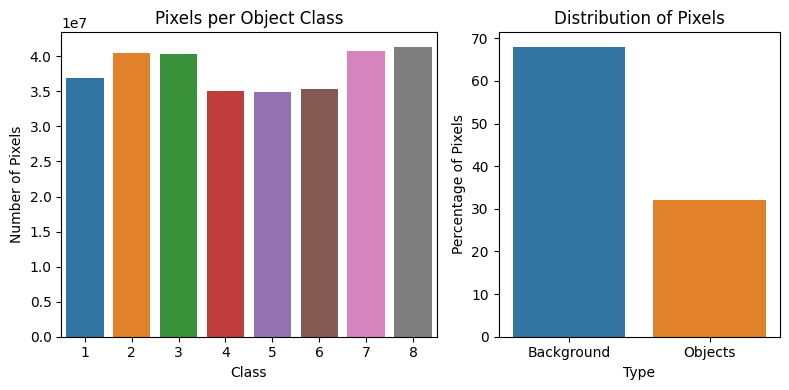

In [ ]:
# Entrenamiento
pixel_count_train = get_distribution_of_pixels("semantic_segmentation_dataset/train/")

Processing images: 100%|██████████| 220/220 [00:16<00:00, 13.08it/s]


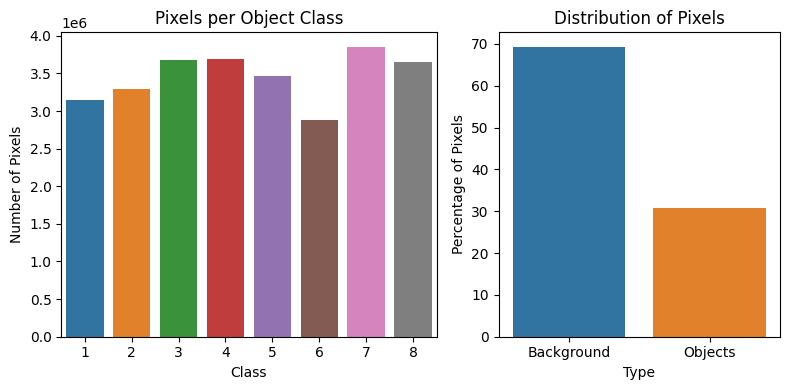

In [ ]:
# Validacion
pixel_count_val = get_distribution_of_pixels("semantic_segmentation_dataset/valid/")

Processing images: 100%|██████████| 104/104 [00:08<00:00, 11.97it/s]


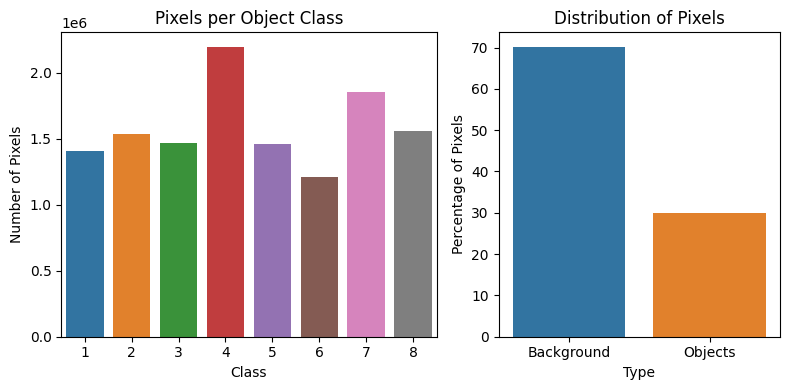

In [ ]:
# Test
pixel_count_test = get_distribution_of_pixels("semantic_segmentation_dataset/test/")

Elaboramos las dos gráficas que irán en la memoria. Por un lado la de las clases y por el otro la del fondo y la de los objetos:

<ipython-input-103-18a78c80f4ca>:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(labels[" Class"][1:9], rotation=90, fontsize=15)
<ipython-input-103-18a78c80f4ca>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(labels[" Class"][1:9], rotation=90, fontsize=15)
<ipython-input-103-18a78c80f4ca>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(labels[" Class"][1:9], rotation=90, fontsize=15)


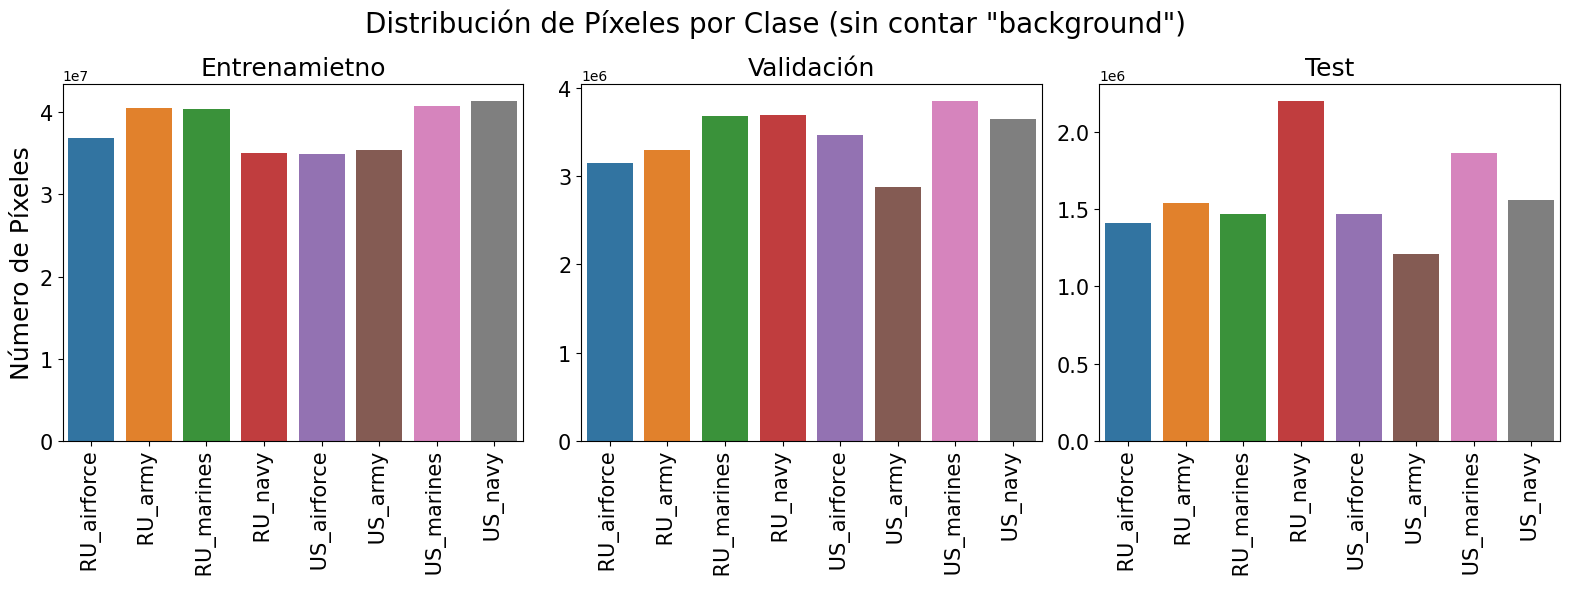

In [ ]:
# Entrenamiento
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
sns.barplot(
    x=range(1, 9),
    y=[pixel_count_train[i] for i in range(1, 9)],
    hue=[str(key) for key in pixel_count_train.keys()], legend=False,
    ax=axs[0]
)
axs[0].set_title("Entrenamietno", fontsize=18)
axs[0].set_ylabel("Número de Píxeles", fontsize=18)
axs[0].set_xticklabels(labels[" Class"][1:9], rotation=90, fontsize=15)
axs[0].tick_params(axis='y', labelsize=15)

# Validacion
sns.barplot(
    x=range(1, 9),
    y=[pixel_count_val[i] for i in range(1, 9)],
    hue=[str(key) for key in pixel_count_val.keys()], legend=False,
    ax=axs[1]
)
axs[1].set_title("Validación", fontsize=18)
axs[1].set_xticklabels(labels[" Class"][1:9], rotation=90, fontsize=15)
axs[1].tick_params(axis='y', labelsize=15)

# Test
sns.barplot(
    x=range(1, 9),
    y=[pixel_count_test[i] for i in range(1, 9)],
    hue=[str(key) for key in pixel_count_test.keys()], legend=False,
    ax=axs[2]
)
axs[2].set_title("Test", fontsize=18)
axs[2].set_xticklabels(labels[" Class"][1:9], rotation=90, fontsize=15)
axs[2].tick_params(axis='y', labelsize=15)

fig.suptitle('Distribución de Píxeles por Clase (sin contar "background")', fontsize=20)
fig.tight_layout()
plt.show()

<ipython-input-113-e9e422be1913>:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(["Objetos", "Fondo"], fontsize=18)
<ipython-input-113-e9e422be1913>:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(["Objetos", "Fondo"], fontsize=18)
<ipython-input-113-e9e422be1913>:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(["Objetos", "Fondo"], fontsize=18)


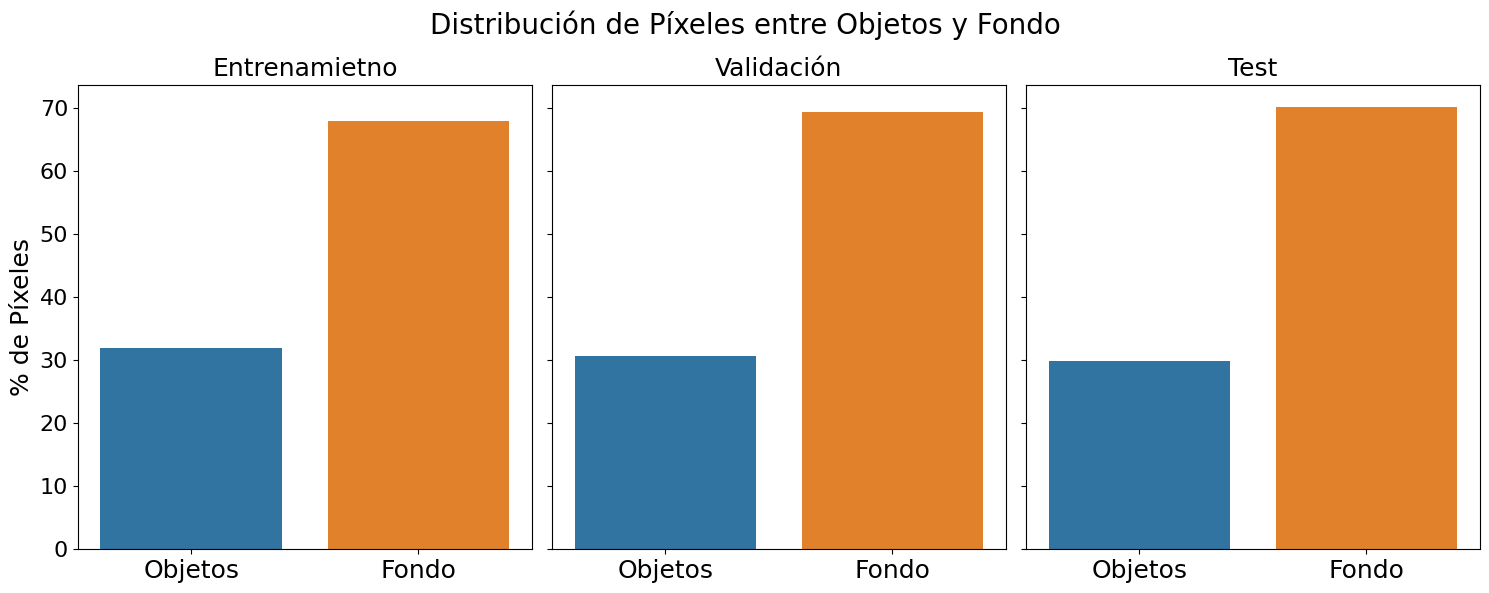

In [ ]:
# Calculamos los porcentajes de los pixeles
total_train_pixels = 640 * 640 * 2328
total_val_pixels = 640 * 640 * 220
total_test_pixels = 640 * 640 * 104

object_train_pixels = sum(pixel_count_train.values())
object_val_pixels = sum(pixel_count_val.values())
object_test_pixels = sum(pixel_count_test.values())

object_train_percentage = (object_train_pixels / total_train_pixels) * 100
object_val_percentage = (object_val_pixels / total_val_pixels) * 100
object_test_percentage = (object_test_pixels / total_test_pixels) * 100

# Hacemos la grafica de barras
fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharey=True)

# Entrenamiento
sns.barplot(
    x=range(2),
    y=[object_train_percentage, 100 - object_train_percentage],
    hue=["Objetos", "Fondo"], legend=False,
    ax=axs[0]
)
axs[0].set_title("Entrenamietno", fontsize=18)
axs[0].set_ylabel("% de Píxeles", fontsize=18)
axs[0].tick_params(axis='y', labelsize=16)
axs[0].set_xticklabels(["Objetos", "Fondo"], fontsize=18)

# Validacion
sns.barplot(
    x=range(2),
    y=[object_val_percentage, 100 - object_val_percentage],
    hue=["Objetos", "Fondo"], legend=False,
    ax=axs[1]
)
axs[1].set_title("Validación", fontsize=18)
axs[1].set_xticklabels(["Objetos", "Fondo"], fontsize=18)

# Test
sns.barplot(
    x=range(2),
    y=[object_test_percentage, 100 - object_test_percentage],
    hue=["Objetos", "Fondo"], legend=False,
    ax=axs[2]
)
axs[2].set_title("Test", fontsize=18)
axs[2].set_xticklabels(["Objetos", "Fondo"], fontsize=18)


fig.suptitle('Distribución de Píxeles entre Objetos y Fondo', fontsize=20)
fig.tight_layout()
plt.show()

## Subida del *Dataset* curado a Drive

Comprimimos el dataset y lo guardamos en Drive:

In [ ]:
shutil.make_archive(
    "/content/valid_semantic_segmentation_dataset",
    "zip",
    "/content",
    "semantic_segmentation_dataset"
)

'/content/valid_semantic_segmentation_dataset.zip'

In [ ]:
shutil.copy(
    "/content/valid_semantic_segmentation_dataset.zip",
    "/content/drive/MyDrive/tfg/datasets/valid_semantic_segmentation_dataset.zip"
)

'/content/drive/MyDrive/tfg/datasets/valid_semantic_segmentation_dataset.zip'